In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
# import pymc3 as pm
# import arviz as az
from datetime import datetime as dt
# import igraph as ig
# from statsmodels.stats.weightstats import ztest
from rdkit import Chem
from rdkit.Chem import Descriptors
import os

In [2]:
plt.style.use("default")
plt.rcParams.update({'font.size': 22})

# Chemical properties figure

- MA changes
- MW change
- Novel fragments

## Set up MA section

In [3]:
#Load compound dates

fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"

cpd_dates_FULL = pickle.load(file=open(fp + "cpd_date_dict_FULL.p", "rb"))

In [4]:
#Load all assemblyGo results

MA_df = pd.read_csv("Data/AssemblyValues/ALLcpds_AssemblyGo.csv")

Get earliest date for compounds

In [5]:
def get_earliest_date(ID, cpd_dates_FULL):
    if ID in cpd_dates_FULL:
        return cpd_dates_FULL[ID][0]
    else:
        return None

In [6]:
tqdm.pandas()

MA_df["earliest_date"] = MA_df["label"].progress_apply(get_earliest_date, args=(cpd_dates_FULL,))

100%|██████████| 1345187/1345187 [00:04<00:00, 282197.44it/s]


Convert dates to datetime objects

In [7]:
import datetime as dt

MA_df["earliest_date"] = pd.to_datetime(MA_df["earliest_date"])
MA_df["date_ordinal"] = MA_df["earliest_date"].map(dt.datetime.toordinal)

In [8]:
print(MA_df)

         Unnamed: 0            label  MA_assemblyGo        time earliest_date  \
0                 0        SCHEMBL10           21.0  120.662484    1980-06-25   
1                 1  SCHEMBL10000006           14.0  119.968879    2007-02-06   
2                 2  SCHEMBL10000077           19.0  119.948782    2010-03-25   
3                 3  SCHEMBL10000078           10.0   28.798358    2010-03-25   
4                 4  SCHEMBL10000080            6.0    0.351274    2010-03-25   
...             ...              ...            ...         ...           ...   
1345182     1345182   SCHEMBL9999740           18.0  120.064376    2013-03-07   
1345183     1345183    SCHEMBL999979           20.0  121.223274    2011-01-20   
1345184     1345184   SCHEMBL9999803           29.0  119.850716    2012-06-07   
1345185     1345185   SCHEMBL9999899           11.0   46.285976    2013-07-25   
1345186     1345186   SCHEMBL9999952           13.0  119.925215    2008-08-14   

         date_ordinal  
0  

Get MA values and statistics from each month

In [9]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [10]:
tqdm.pandas()

MA_df["month"] = MA_df["earliest_date"].progress_apply(get_month)

100%|██████████| 1345187/1345187 [00:19<00:00, 70178.84it/s] 


In [11]:
MA_df_months = MA_df.groupby("month")["MA_assemblyGo"].apply(list).reset_index(name="MAs")

print(MA_df_months)

       month                                                MAs
0    1965-02                                       [17.0, 18.0]
1    1965-05                                              [7.0]
2    1965-06                                              [9.0]
3    1966-03                                              [6.0]
4    1966-07                                              [6.0]
..       ...                                                ...
580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...
581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...
582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...
583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...
584      NaT  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

[585 rows x 2 columns]


In [12]:
def get_mean(MAs):
    try:
        return np.mean(MAs)
    except:
        return 0
    
def get_std(MAs):
    try:
        return np.std(MAs)
    except:
        return 0
    
def get_IQR(MAs):
    try:
        return stats.iqr(MAs, interpolation="midpoint")
    except:
        return 0

In [13]:
tqdm.pandas() 

MA_df_months["avg"] = MA_df_months["MAs"].progress_apply(get_mean)
MA_df_months["std"] = MA_df_months["MAs"].progress_apply(get_std)
MA_df_months["iqr"] = MA_df_months["MAs"].progress_apply(get_IQR)

100%|██████████| 585/585 [00:00<00:00, 1180.10it/s]


In [14]:
MA_df_months["date"] = pd.to_datetime(MA_df_months["month"])
MA_df_months["date_ordinal"] = MA_df_months["date"].map(dt.datetime.toordinal)

Text(0, 0.5, 'Assembly Index')

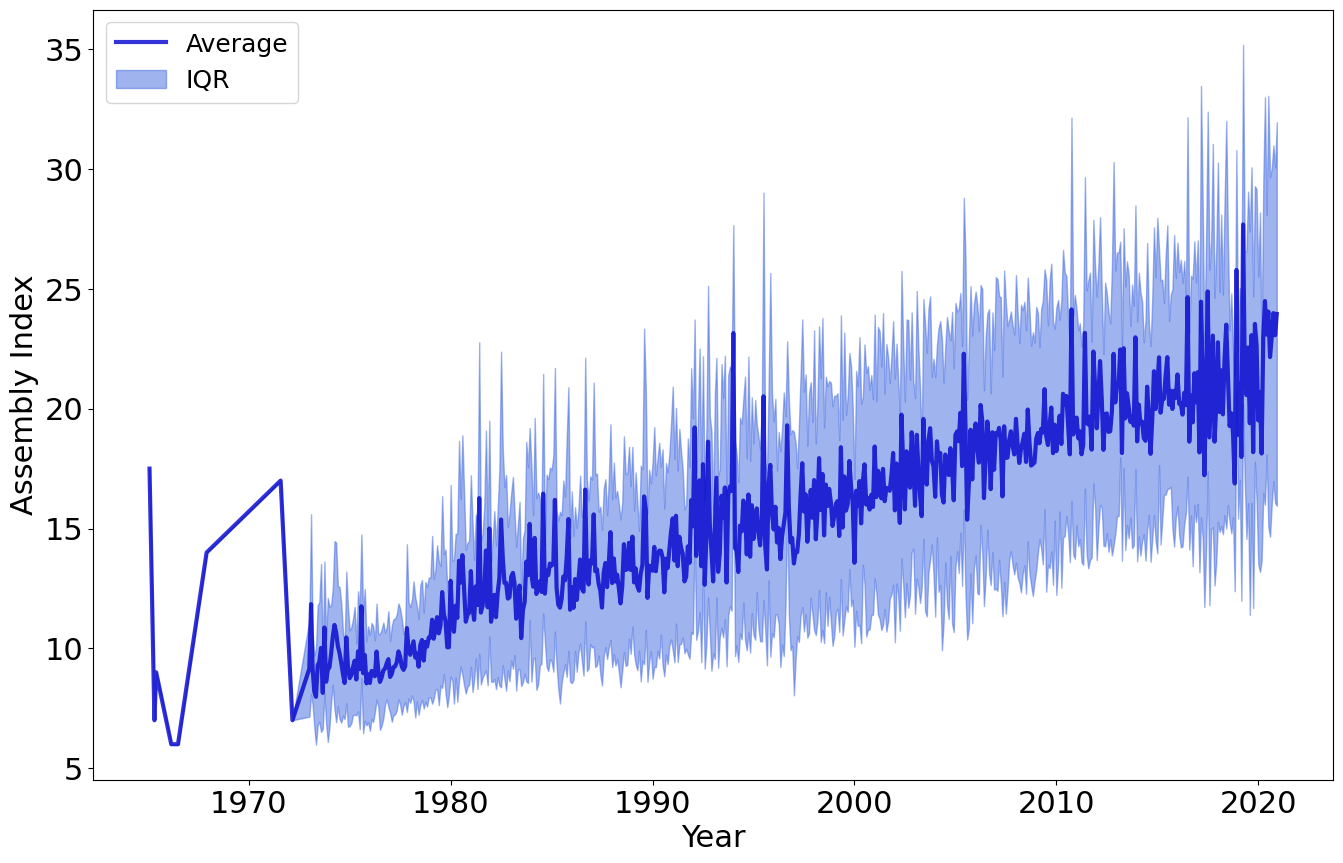

In [15]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Set up molecular weight figure

In [16]:
## Read molecular weight df (obtained from full surechembl database)
filtered_sc_df = pd.read_csv("Data/molecular_weight_chemblCpds.csv")

In [17]:
#Merge with MA results to link dates with MW

mw_df = pd.merge(left=MA_df, right=filtered_sc_df, left_on="label", right_on="SureChEMBL_ID", how="outer")

print(mw_df)

         Unnamed: 0_x            label  MA_assemblyGo        time  \
0                   0        SCHEMBL10           21.0  120.662484   
1                   1  SCHEMBL10000006           14.0  119.968879   
2                   2  SCHEMBL10000077           19.0  119.948782   
3                   3  SCHEMBL10000078           10.0   28.798358   
4                   4  SCHEMBL10000080            6.0    0.351274   
...               ...              ...            ...         ...   
1345383       1345182   SCHEMBL9999740           18.0  120.064376   
1345384       1345183    SCHEMBL999979           20.0  121.223274   
1345385       1345184   SCHEMBL9999803           29.0  119.850716   
1345386       1345185   SCHEMBL9999899           11.0   46.285976   
1345387       1345186   SCHEMBL9999952           13.0  119.925215   

        earliest_date  date_ordinal    month  Unnamed: 0_y    SureChEMBL_ID  \
0          1980-06-25        722991  1980-06           2.0        SCHEMBL10   
1          20

Statistics over each month

In [18]:
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")

tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.datetime.toordinal)

100%|██████████| 585/585 [00:00<00:00, 1634.32it/s]


Text(0, 0.5, 'Molecular Weight (Daltons)')

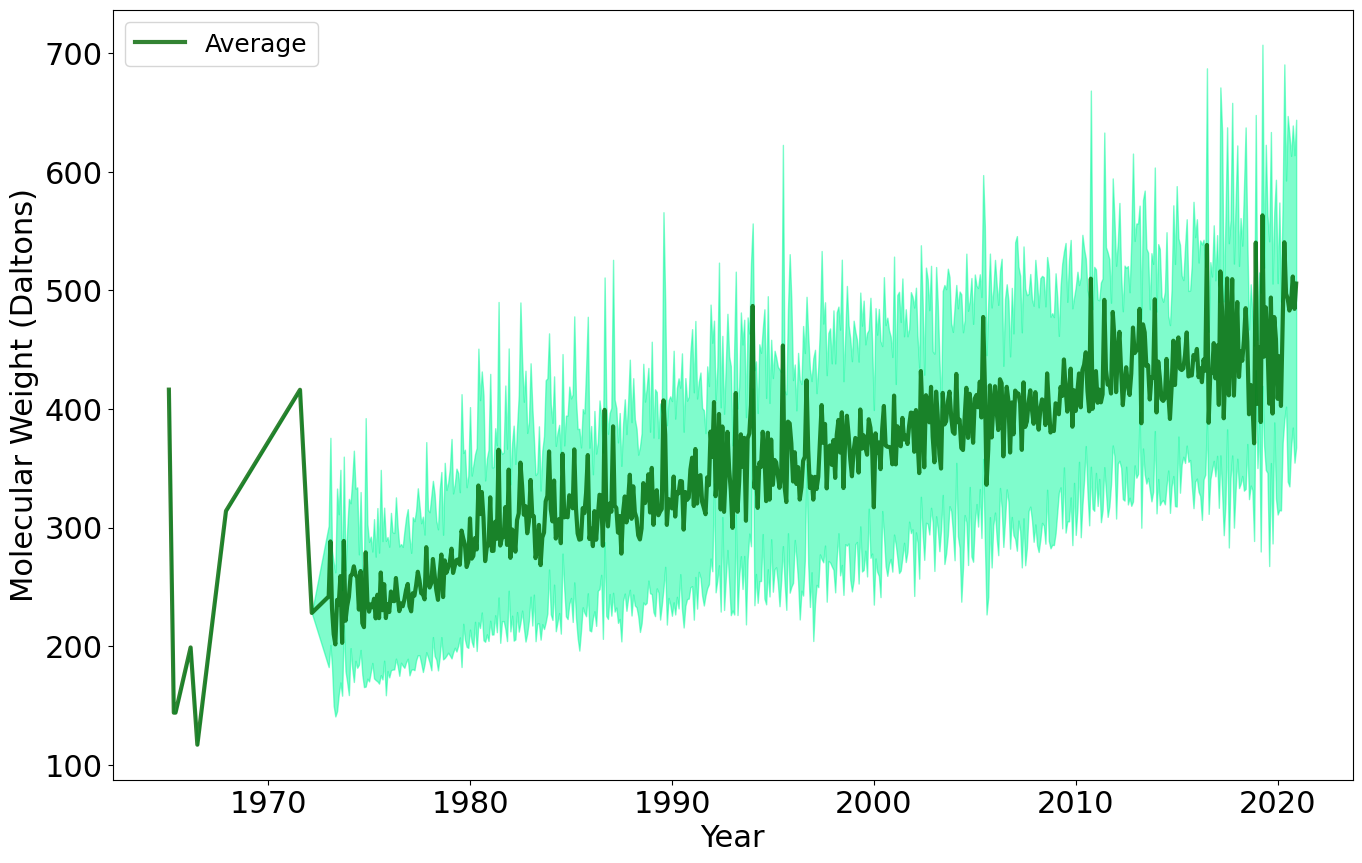

In [19]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

## Fragment figure

In [21]:
new_frag_count = pickle.load(file=open("Data/AssemblyValues/Fragments/author_newFragCount.p", "rb"))

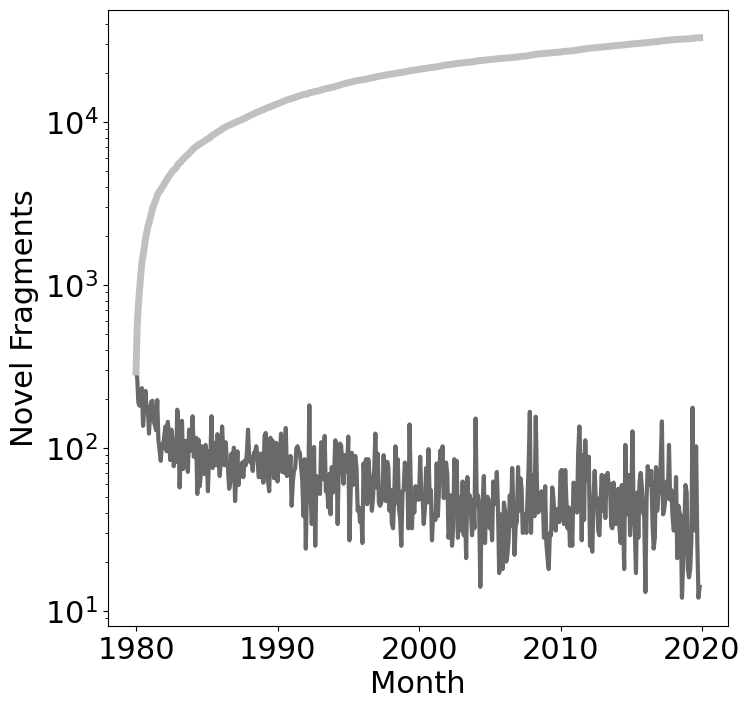

In [42]:
plt.figure(figsize=(8,8))


plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color="dimgray")

plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color="silver")

plt.yscale("log")

plt.xlabel("Month")
plt.ylabel("Novel Fragments")

plt.show()

## Full Figure

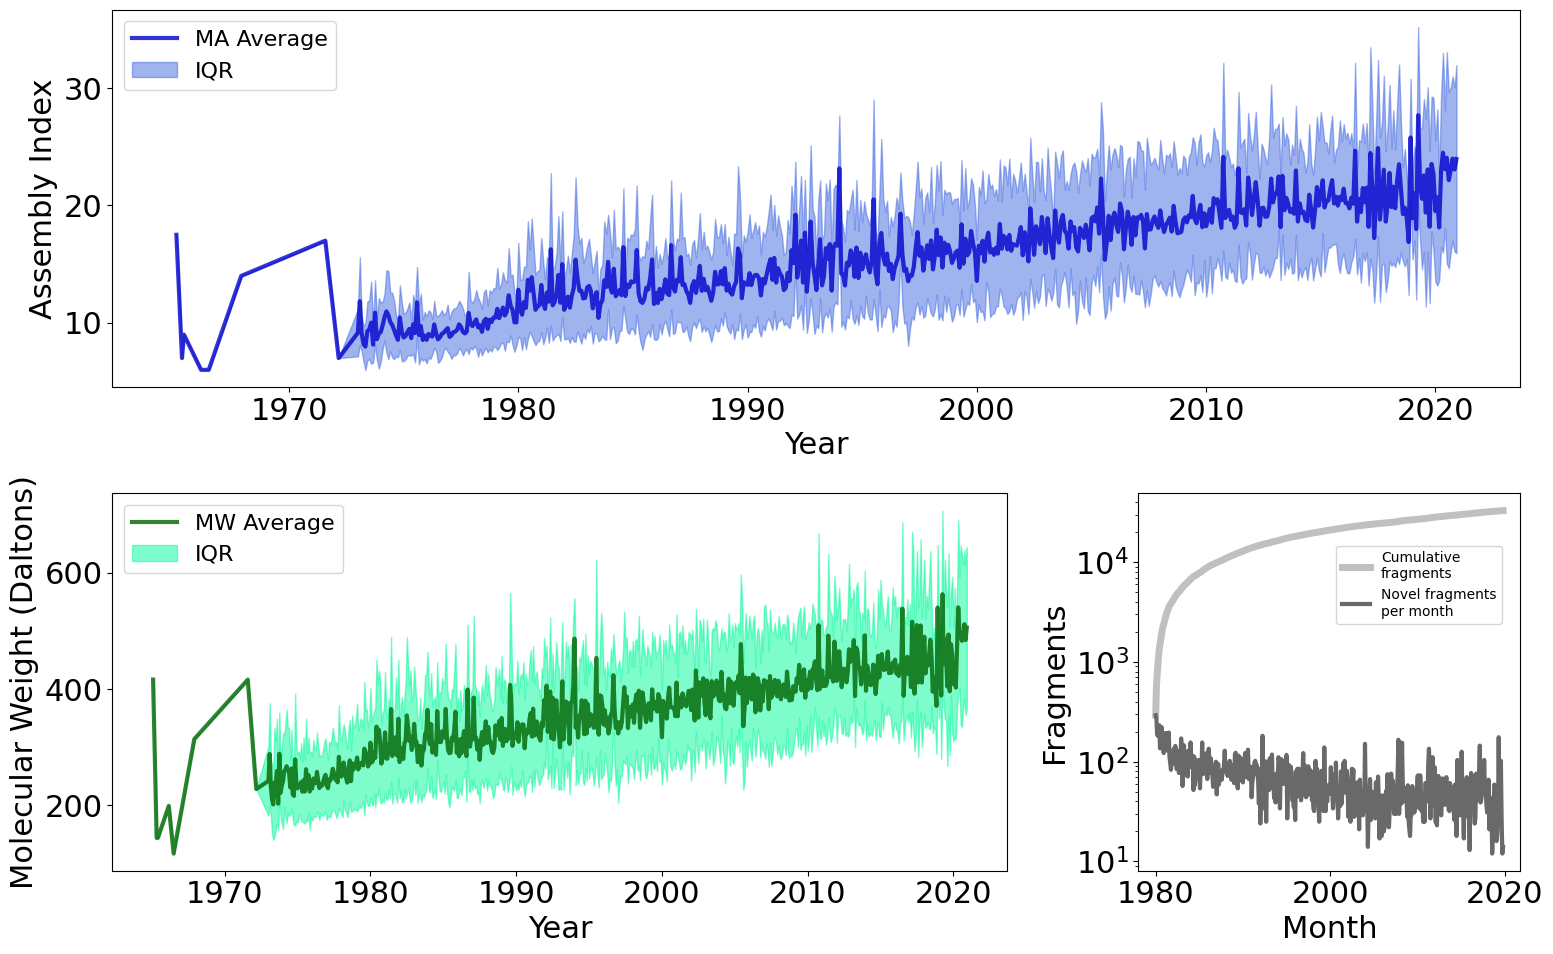

In [53]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2,3)

fig = plt.figure(figsize=(16,10))

## MA Figure
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

ax1.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

ax1.legend(loc="upper left", prop={"size":"16"})
ax1.set_xlabel("Year")
ax1.set_ylabel("Assembly Index")


## MW Figure
ax2 = fig.add_subplot(gs[1,0:2])
ax2.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="IQR")

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Molecular Weight (Daltons)")


## Fragment figure
ax3 = fig.add_subplot(gs[1,2])

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color="silver", label="Cumulative\nfragments")

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color="dimgray", label="Novel fragments\nper month")



ax3.set_yscale("log")

ax3.legend(bbox_to_anchor=(0.5, 0.88), prop={"size":10})
ax3.set_xlabel("Month")
ax3.set_ylabel("Fragments")

plt.tight_layout()
